In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

## Karpathy's Zero to Hero course
In this notebook I'll try to keep up while watching these videos


In [ ]:
# graph stuff copied from github
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.name, n.data, n._grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

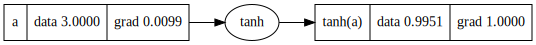

In [ ]:
# main backprop class, very cool
# I love chain rule
class Value:
  def __init__(self, data, name='', _children=[], _op=''):
    self.data = data
    self._prev = _children
    self._op = _op
    self._grad = 1
    self.name = name if name != '' else 'val'

  def __repr__(self):
    return f"Value({self.data})"

  def recalculate(self):
    # does not recalculate gradient tho
    if not len(self._prev):
      return
    for c in self._prev:
      c.recalculate()
    if self._op == '+':
      self.data = self._prev[0].data + self._prev[1].data
    elif self._op == '*':
      self.data = self._prev[0].data * self._prev[1].data
    elif self._op == 'tanh':
      self.data = self._tanh_function(self._prev[0].data)

  def backprop(self):
    for i, c in enumerate(self._prev):
      if self._op == '+':
        c._grad = 1 * self._grad
      if self._op == '-' and i == 0:
        c._grad = 1 * self._grad
      if self._op == '-' and i == 1:
        c._grad = -1 * self._grad
      elif self._op == '*' and i == 0:
        c._grad = self._prev[1].data * self._grad
      elif self._op == '*' and i == 1:
        c._grad = self._prev[0].data * self._grad
      elif self._op == '**':
        c._grad = self._prev[1].data * self._prev[0].data ** (self._prev[1].data - 1) * self._grad
      elif self._op == 'tanh':
        c._grad = (1 - self.data**2) * self._grad
      else:
        pass
      if c._op:
        c.backprop()
  def reset_grad(self):
    self._grad = 1
    for c in self._prev:
      c.reset_grad()

  def plot(self):
    draw_dot(self)

  def tanh(self):
    t = self._tanh_function(self.data)
    out = Value(t, f'tanh({self.name})', (self,), 'tanh')
    return out

  def _tanh_function(self, x):
    # print('TANH', x, self)
    return (math.exp(2*x) - 1)/(math.exp(2*x) + 1)


  def __add__(self, other):
    if isinstance(other, Value):
      return Value(self.data + other.data, f'{self.name}+{other.name}', (self, other), '+')
    return Value(self.data + other, f'{self.name}+val', (self, Value(other)), '+')

  def __sub__(self, other):
    if isinstance(other, Value):
      return Value(self.data - other.data, f'{self.name}-{other.name}', (self, other), '-')
    return Value(self.data - other, f'{self.name}-val', (self, Value(other)), '-')


  def __radd__(self, other):
    if isinstance(other, Value):
      return Value(self.data + other.data, f'{self.name}+{other.name}', (self, other), '+')
    return Value(self.data + other, f'{self.name}+val', (self, Value(other)), '+')

  def __mul__(self, other):
    if isinstance(other, Value):
      return Value(self.data * other.data, f'{self.name}*{other.name}', (self, other), '*')
    return Value(self.data * other, f'{self.name}*{other}', (self, Value(other)), '*')

  def __truediv__(self, other):
    return self * other ** (-1)

  def __rmul__(self, other):
    if isinstance(other, Value):
      return Value(self.data * other.data, f'{self.name}*{other.name}', (self, other), '*')
    return Value(self.data * other, f'{self.name}*{other}', (self, Value(other)), '*')

  def __pow__(self, other):
    if isinstance(other, int):
      return Value(self.data ** other, f'{self.name}**{other}', (self, Value(other)), '**')
    return Value(self.data ** other.data, f'{self.name}**{other.name}', (self, other), '**')

a = Value(3, 'a')
b = a.tanh()
b.backprop()
draw_dot(b)

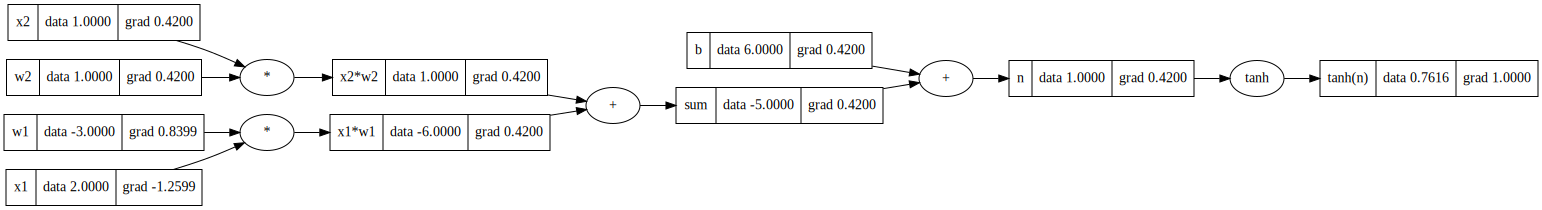

In [ ]:
# Testing one neuron with 2 inputs => 2 weights + 1 bias
x1 = Value(2.0, name='x1')
x2 = Value(1.0, name='x2')

w1 = Value(-3.0, name='w1')
w2 = Value(1.0, name='w2')
b = Value(6.0, name='b')

x1w1 = x1 * w1
x2w2 = x2 * w2
sumx = x1w1 + x2w2
sumx.name = 'sum'

n = sumx + b
n.name = 'n'

t = n.tanh()
t.backprop()
draw_dot(t)
# very cool

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.nin = nin
    self.w = [Value(random.uniform(-1,1), f'w{i+1}') for i in range(nin)]
    self.b = Value(random.uniform(-1,1), 'b')

  def forward(self, inp):
    if len(inp) != len(self.w):
      raise Exception('length of inp and w do not match')
    # calculate the forward value of this neuron
    act = sum([wi * inp[i] for i, wi in enumerate(self.w)], self.b)
    # return act.tanh()
    return act

  def params(self):
    return self.w + [self.b]


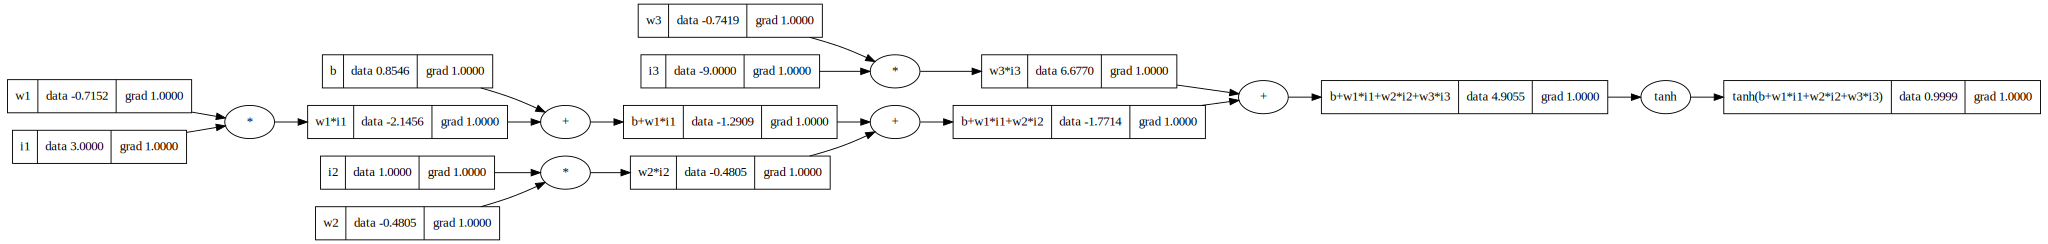

In [ ]:
# Let's test a neuron with 3 inputs
inp  = [Value(3.0, 'i1'), Value(1.0, 'i2'), Value(-9.0, 'i3')]
n = Neuron(3)
out = n.forward(inp)
draw_dot(out)

In [ ]:
class Column:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def forward(self, inp):
    outs = [n.forward(inp) for n in self.neurons]
    return outs

  def params(self):
    return [el for p in (n.params() for n in self.neurons) for el in p]

In [ ]:
class NeuralNet:
  def __init__(self, nin, counts):
    c = [nin] + counts
    self.columns = [Column(i, o) for i, o in zip(c, c[1:])]

  def forward(self, inp):
    for c in self.columns:
      inp = c.forward(inp)
    return inp

  def params(self):
    return[el for p in (c.params() for c in self.columns) for el in p]


Run 0, loss: 319.8582734228244
Run 1, loss: 260.00001126491776
Run 2, loss: 260.0000112641683
Run 3, loss: 260.00001126341874
Run 4, loss: 260.0000112626695
Run 5, loss: 260.0000112619201
Run 6, loss: 260.0000112611708
Run 7, loss: 260.0000112604216
Run 8, loss: 260.0000112596725
Run 9, loss: 260.0000112589234
Predictions
[Value(-0.999998619379634), Value(-0.9999994755811676)]


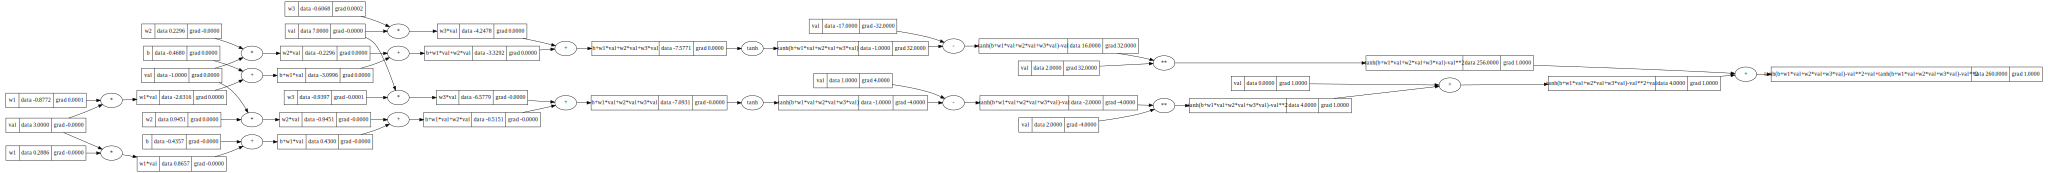

In [ ]:
# A very simple network (no tanh) that should give:
# (x + 2y, 3y - 2z)
# 3 inputs, 2 outputs, only 1 layer
n = NeuralNet(3, [2])
inp = [Value(3.0), Value(-1.0), Value(7.0)]
target = [inp[0] + 2 * inp[1], 3 * inp[1] - 2 * inp[2]]
target = [Value(t.data) for t in target]

for i in range(10):
  val = n.forward(inp)
  loss = sum((v - tar) ** 2 for v, tar in zip(val, target))
  if loss.data < 0.01:
    break
  loss.reset_grad()
  loss.backprop()
  for p in n.params():
    p.data = (p + p._grad * Value(-0.01)).data
  print(f'Run {i}, loss: {loss.data}')

print('Predictions')
print(val)
draw_dot(loss)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

n = NeuralNet(3, [4, 4, 1])

for i in range(100):
  ypred = [n.forward(x)[0] for x in xs]
  loss = sum((y1 - y2) ** 2 for y1, y2 in zip(ypred, ys))
  loss.reset_grad()
  loss.backprop()
  # print([p._grad for p in n.params()])
  for j, p in enumerate(n.params()):
    p.data = (p - p._grad * (1 - 0.9 ** j)).data
  print(f'round {i} loss: {loss}')

round 0 loss: Value(3.1521588008509394)
round 1 loss: Value(3.4119003210653998)
round 2 loss: Value(3.5944910527541034)
round 3 loss: Value(3.73624983446819)
round 4 loss: Value(3.8522786485292277)
round 5 loss: Value(3.9504877498681332)
round 6 loss: Value(4.0355846825367365)
round 7 loss: Value(4.1106135460029956)
round 8 loss: Value(4.17766230646486)
round 9 loss: Value(4.238227936519396)
round 10 loss: Value(4.29342146647972)
round 11 loss: Value(4.344090761665697)
round 12 loss: Value(4.390897859827931)
round 13 loss: Value(4.434369734457457)
round 14 loss: Value(4.474932774211651)
round 15 loss: Value(4.512936888174487)
round 16 loss: Value(4.548672780429522)
round 17 loss: Value(4.582384597903974)
round 18 loss: Value(4.614279366240178)
round 19 loss: Value(4.6445341471598685)
round 20 loss: Value(4.6733015483005484)
round 21 loss: Value(4.7007140212810326)
round 22 loss: Value(4.726887254752011)
round 23 loss: Value(4.751922882126957)
round 24 loss: Value(4.775910663806304)
rou